In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import datetime
import geopandas as gpd

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import helper

In [2]:
import matplotlib.style as style
plt.style.use("markerr.mplstyle")

In [3]:
zri = pd.read_csv('long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )

# source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2018.html
zips = gpd.read_file('cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp')
zips['GEOID10'] = zips['GEOID10'].astype(int)
target_zips = pd.read_csv('target.csv', index_col = 0)



#### prepping for mapping 

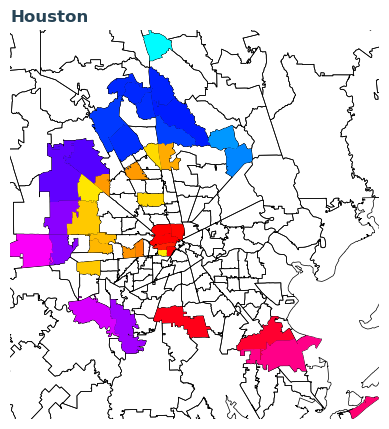

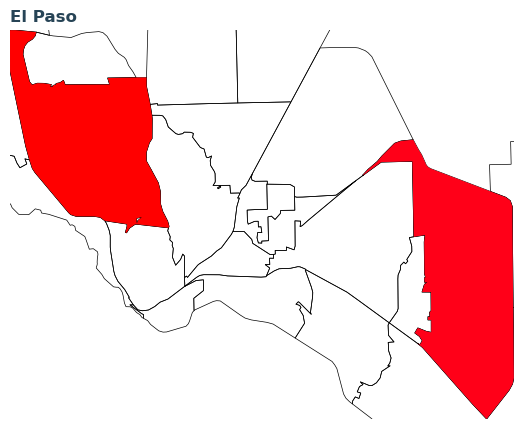

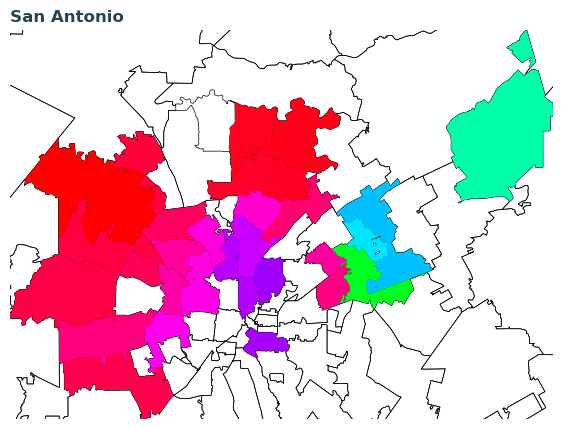

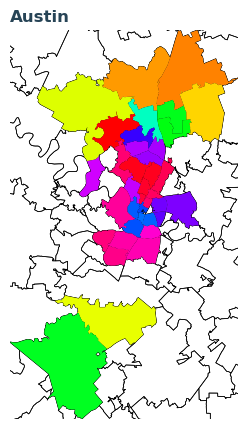

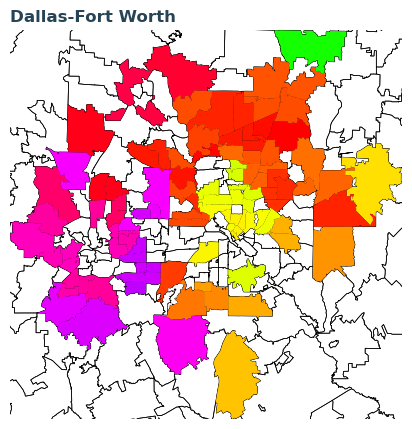

In [4]:
# lists of relevent zipcodes
houston_zips_list = list(target_zips[target_zips['City']=='Houston']['zip_code'].unique())
paso_zips_list = list(target_zips[target_zips['City']=='El Paso']['zip_code'].unique())
san_zips_list = list(target_zips[target_zips['City']=='San Antonio']['zip_code'].unique())
austin_zips_list = list(target_zips[target_zips['City']=='Austin']['zip_code'].unique())
dallas_zips_list = list(target_zips[target_zips['City']=='Dallas-Fort Worth']['zip_code'].unique())

# limitting the zips to just inside the region around TX 
zips = zips[zips['AFFGEOID10'].str[0:10] == '8600000US7'].reset_index()

# limiting to the inidvidual regions of interest
houston_zips = zips.loc[zips.loc[:,'GEOID10'].isin(houston_zips_list),:]
paso_zips = zips.loc[zips.loc[:,'GEOID10'].isin(paso_zips_list),:]
san_zips = zips.loc[zips.loc[:,'GEOID10'].isin(san_zips_list),:]
austin_zips = zips.loc[zips.loc[:,'GEOID10'].isin(austin_zips_list),:]
dallas_zips = zips.loc[zips.loc[:,'GEOID10'].isin(dallas_zips_list),:]

# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='Black', linewidth=.5,ax=ax)
    different_metros[metro].plot(ax=zip_boundry_map, zorder=2, legend=False, column = 'GEOID10', cmap='hsv')

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = different_metros[metro].total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro)
    plt.show()

In [5]:
# zri_shift 6-12 months
zri_shift, zri_shift_X_vals = helper.time_lag_merge(zri, zri, {
    6:['zori_ssa'],
    7:['zori_ssa'],
    12:['zori_ssa'],
    18:['zori_ssa']
},
                                          return_cols = True
                                         )
zri_shift = zri_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff__lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_7_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_12_month_shift'])
zri_shift.loc[:,'zori_ssa_12_diff_lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_18_month_shift'])
zri_shift = zri_shift[['Time','zip_code','zori_ssa','zori_ssa_6_month_shift',
                       'zori_ssa_12_month_shift',
                       'zori_ssa_1_diff__lag_6','zori_ssa_6_diff_lag_6',
                       'zori_ssa_12_diff_lag_6']]


In [8]:
X_vals = ['zori_ssa_6_month_shift',
                       'zori_ssa_12_month_shift',
                       'zori_ssa_1_diff__lag_6','zori_ssa_6_diff_lag_6',
                       'zori_ssa_12_diff_lag_6']
y_val = 'zori_ssa'

# for metro in metros:
train = zri_shift.loc[zri_shift['Time']<datetime.datetime(2021,1,2),:].reset_index(drop=True)
test = zri_shift.loc[zri_shift['Time']>datetime.datetime(2021,1,2),:].reset_index(drop=True)
cat_feats_=[]

scaler = StandardScaler(with_mean=False)
lasso = Lasso(max_iter = 50000, random_state = 33)

X = train[X_vals]
transformer = ColumnTransformer([("Cat", 
                                  OneHotEncoder(handle_unknown = 'ignore'), 
                                  cat_feats_)], remainder='passthrough')
X = transformer.fit_transform(X)
X = scaler.fit_transform(X)
y = train[y_val]

# Grid Search set up.

alphas = [0.3, 0.6, 1]
tuned_parameters = [{'alpha': alphas}]
print(f'Performing Grid Search with alphas of: {alphas}')
clf = GridSearchCV(lasso, tuned_parameters, 
                    cv=3,n_jobs = -1,
                  scoring = 'neg_root_mean_squared_error')
# best_alpha = clf.best_params_['alpha']
clf.fit(X, y)

X_test = test[X_vals]
X_test = transformer.transform(X_test)
X_test = scaler.transform(X_test)
y_test = test[y_val]
y_predicted = clf.predict(X_test)
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_predicted

rms = mean_squared_error(y_test, y_predicted, squared=False)
test.loc[:,'pred'] = y_predicted

Performing Grid Search with alphas of: [0.3, 0.6, 1]


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


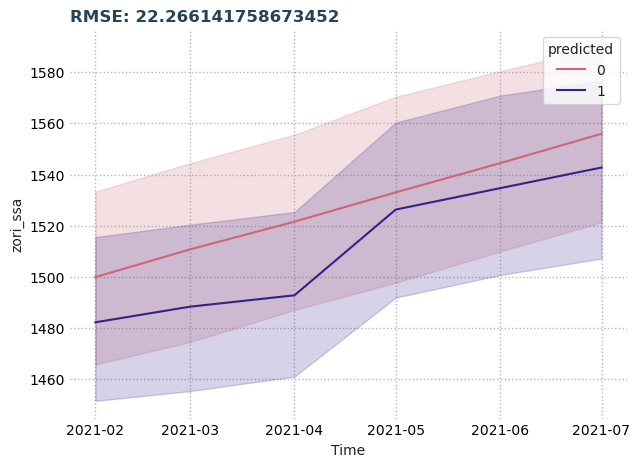

In [9]:
graph_df1 = test[['Time',y_val]]
graph_df1.loc[:,'predicted'] = 0 
graph_df2 = test[['Time','pred']].rename(columns={'pred':y_val})
graph_df2.loc[:,'predicted'] = 1
graph_df = pd.concat([graph_df1,graph_df2]).reset_index(drop=True)

g = sns.lineplot(data = graph_df, x = 'Time',y = y_val, hue = 'predicted')
plt.title(f'RMSE: {rms}')
plt.show()

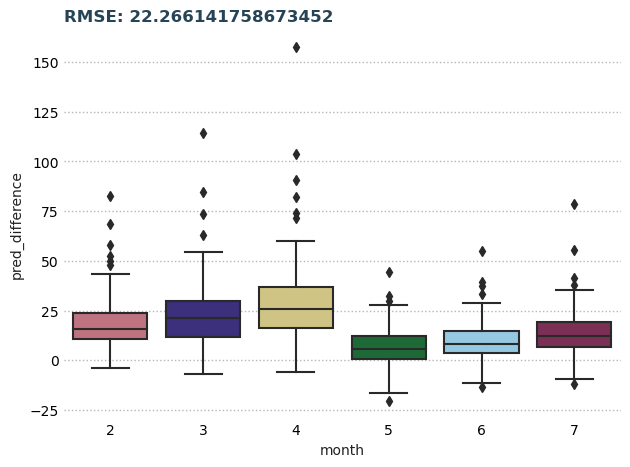

In [10]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
g = sns.boxplot(data = graph_df, x = 'month',y = 'pred_difference', 
                )
plt.title(f'RMSE: {rms}')
plt.show()

In [23]:
coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
coef_df

,features,coefs,coefs_abs
0,zori_ssa_6_month_shift,239.694140,239.694140
1,zori_ssa_1_diff__lag_6,17.752829,17.752829
2,zori_ssa_6_diff_lag_6,-5.475895,5.475895
3,zori_ssa_12_month_shift,0.440057,0.440057


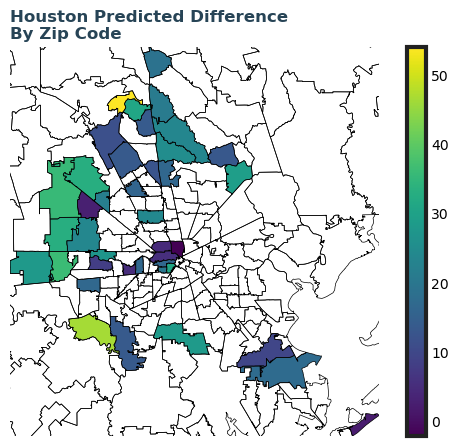

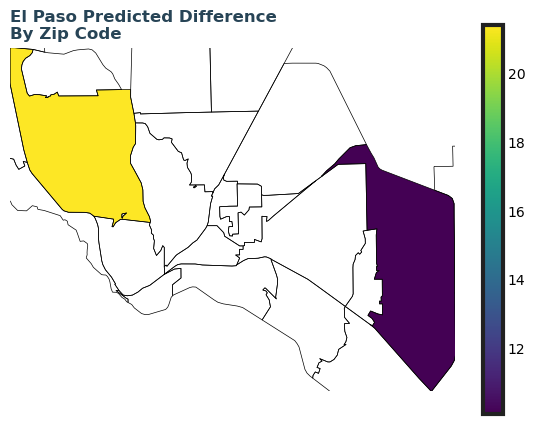

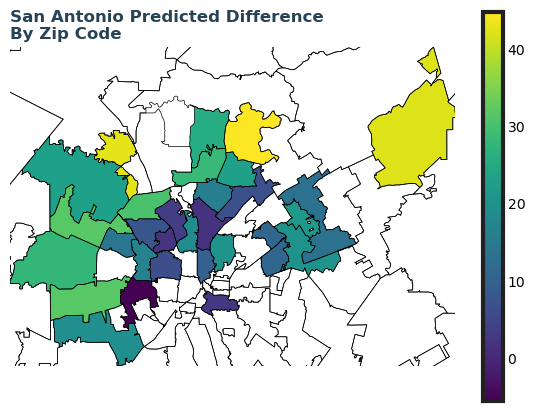

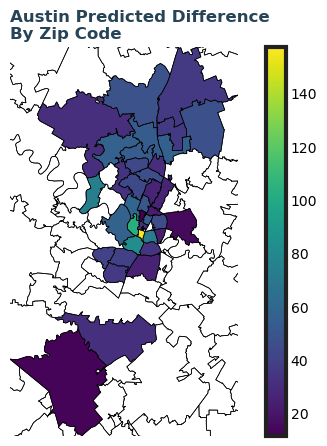

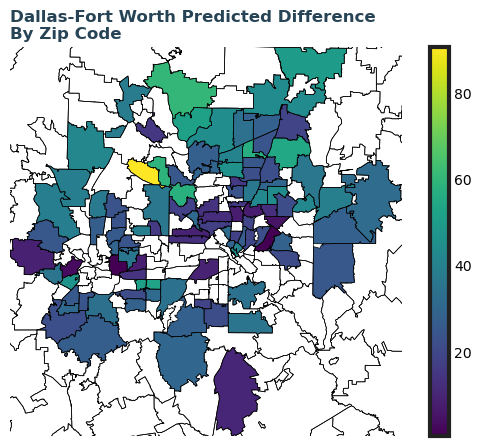

In [21]:
map_ = test[test['Time'].dt.month==4]
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():


    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='Black', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["pred_difference"], 
    #               scheme='equal_interval', k=4,
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro+' Predicted Difference\nBy Zip Code')
    plt.show()

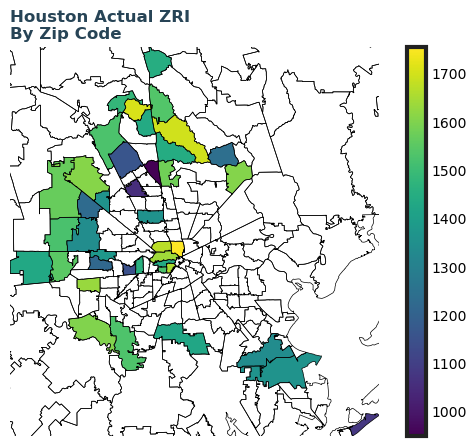

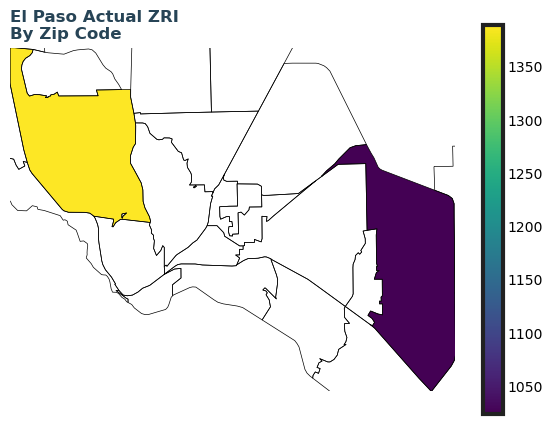

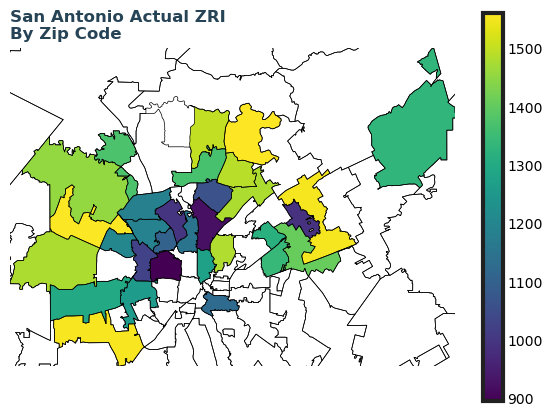

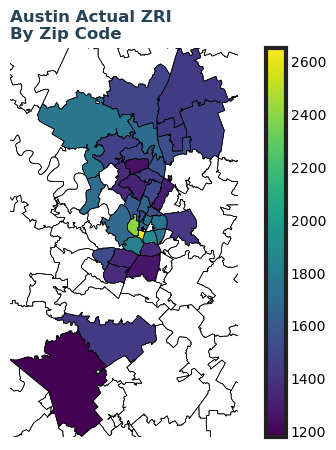

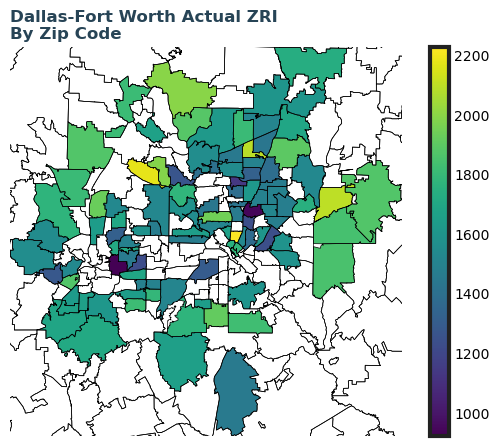

In [22]:
map_ = test[test['Time'].dt.month==4]
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():


    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='Black', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["zori_ssa"], 
    #               scheme='equal_interval', k=4,
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' Actual ZRI\nBy Zip Code')
    plt.show()

In [ ]:
#### using less features

In [27]:
# zri_shift 6-12 months
zri_shift, zri_shift_X_vals = helper.time_lag_merge(zri, zri, {
    6:['zori_ssa'],
    7:['zori_ssa'],
    12:['zori_ssa'],
},
                                          return_cols = True
                                         )
zri_shift = zri_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff_lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_7_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_12_month_shift'])
zri_shift = zri_shift[['Time','zip_code','zori_ssa','zori_ssa_6_month_shift',
                       'zori_ssa_1_diff_lag_6','zori_ssa_6_diff_lag_6']]

In [28]:
X_vals = ['zori_ssa_6_month_shift',
                       'zori_ssa_1_diff_lag_6','zori_ssa_6_diff_lag_6'
                       ]
y_val = 'zori_ssa'

# for metro in metros:
train = zri_shift.loc[zri_shift['Time']<datetime.datetime(2021,1,2),:].reset_index(drop=True)
test = zri_shift.loc[zri_shift['Time']>datetime.datetime(2021,1,2),:].reset_index(drop=True)
cat_feats_=[]

scaler = StandardScaler(with_mean=False)
lasso = Lasso(max_iter = 50000, random_state = 33)

X = train[X_vals]
transformer = ColumnTransformer([("Cat", 
                                  OneHotEncoder(handle_unknown = 'ignore'), 
                                  cat_feats_)], remainder='passthrough')
X = transformer.fit_transform(X)
X = scaler.fit_transform(X)
y = train[y_val]

# Grid Search set up.

alphas = [0.3, 0.6, 1]
tuned_parameters = [{'alpha': alphas}]
print(f'Performing Grid Search with alphas of: {alphas}')
clf = GridSearchCV(lasso, tuned_parameters, 
                    cv=3,n_jobs = -1,
                  scoring = 'neg_root_mean_squared_error')
# best_alpha = clf.best_params_['alpha']
clf.fit(X, y)

X_test = test[X_vals]
X_test = transformer.transform(X_test)
X_test = scaler.transform(X_test)
y_test = test[y_val]
y_predicted = clf.predict(X_test)
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_predicted

rms = mean_squared_error(y_test, y_predicted, squared=False)
test.loc[:,'pred'] = y_predicted

Performing Grid Search with alphas of: [0.3, 0.6, 1]


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


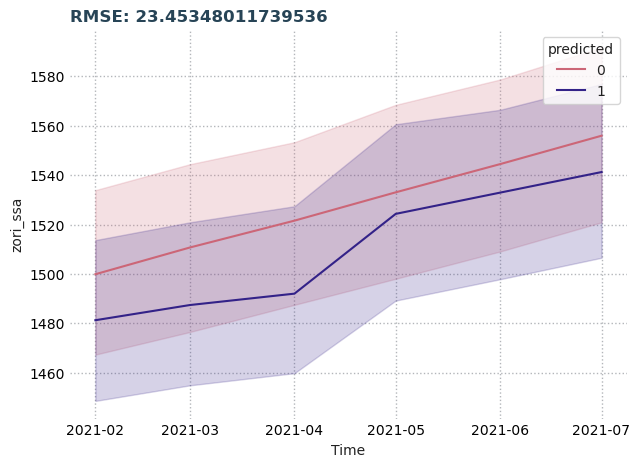

In [29]:
graph_df1 = test[['Time',y_val]]
graph_df1.loc[:,'predicted'] = 0 
graph_df2 = test[['Time','pred']].rename(columns={'pred':y_val})
graph_df2.loc[:,'predicted'] = 1
graph_df = pd.concat([graph_df1,graph_df2]).reset_index(drop=True)

g = sns.lineplot(data = graph_df, x = 'Time',y = y_val, hue = 'predicted')
plt.title(f'RMSE: {rms}')
plt.show()

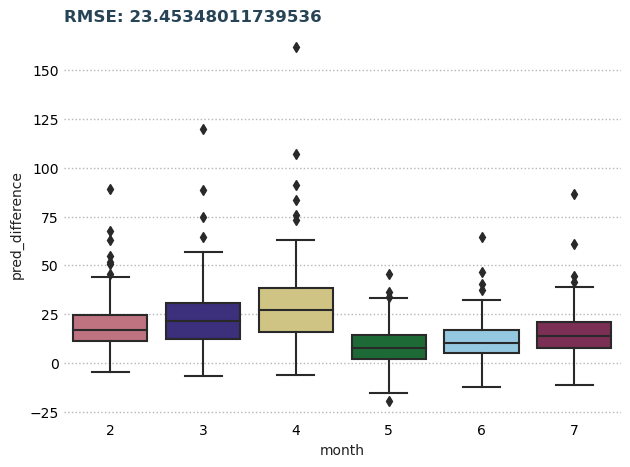

In [30]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
g = sns.boxplot(data = graph_df, x = 'month',y = 'pred_difference', 
                )
plt.title(f'RMSE: {rms}')
plt.show()

In [31]:
coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
coef_df

,features,coefs,coefs_abs
0,zori_ssa_6_month_shift,241.963477,241.963477
1,zori_ssa_1_diff_lag_6,17.688966,17.688966
2,zori_ssa_6_diff_lag_6,-5.322558,5.322558


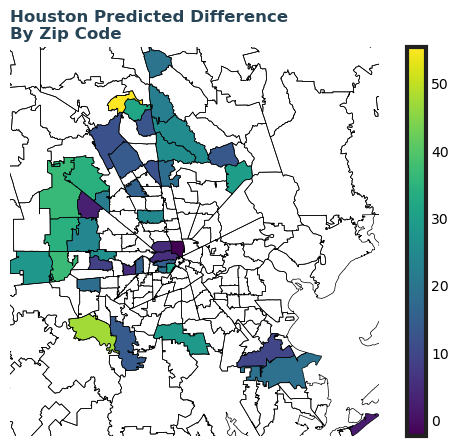

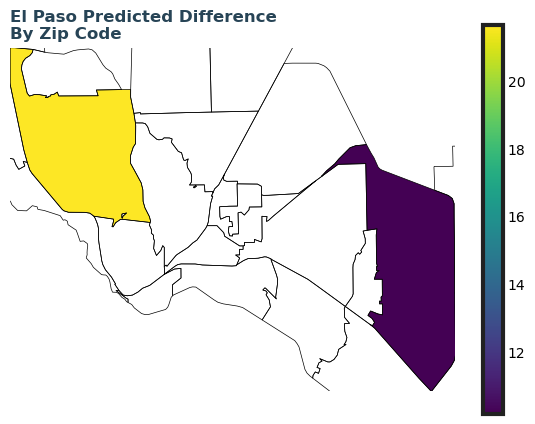

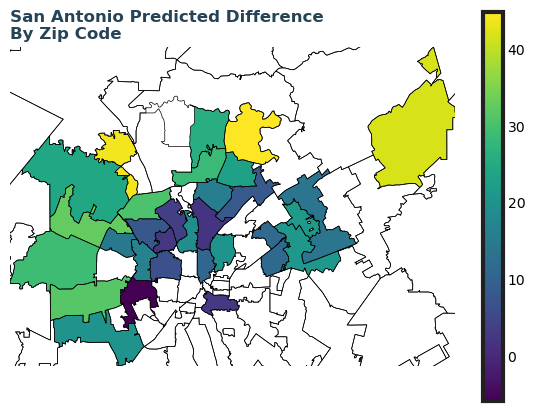

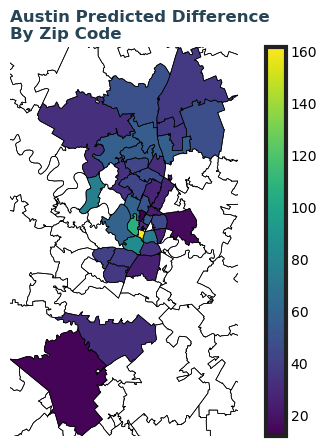

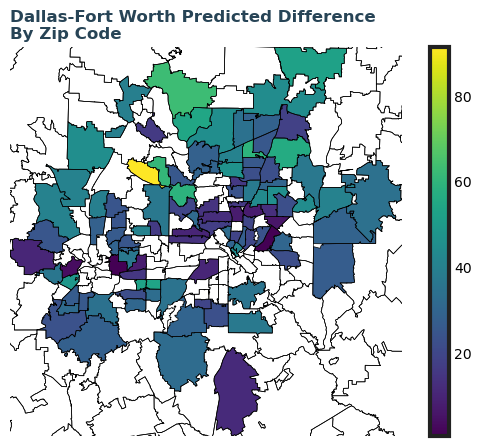

In [32]:
map_ = test[test['Time'].dt.month==4]
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():


    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='Black', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["pred_difference"], 
    #               scheme='equal_interval', k=4,
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro+' Predicted Difference\nBy Zip Code')
    plt.show()

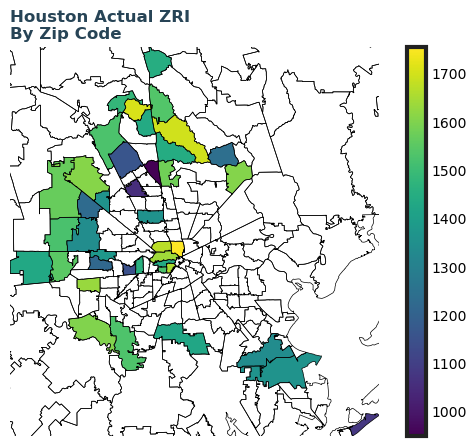

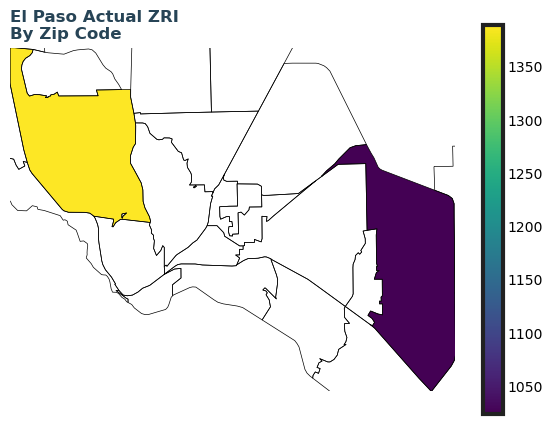

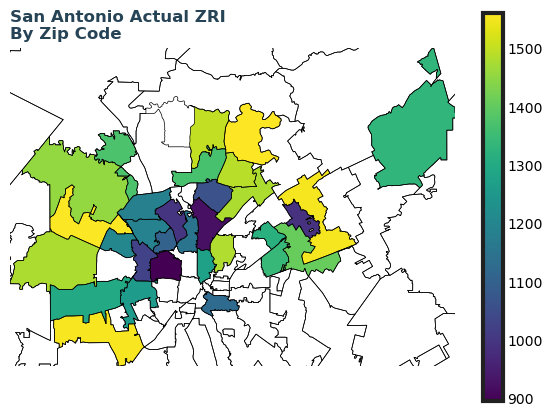

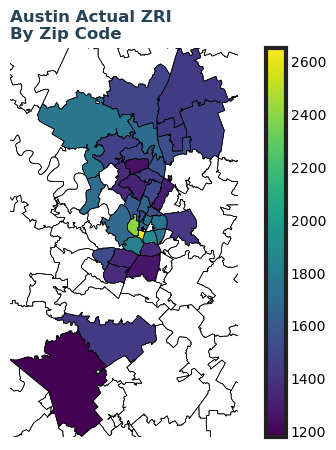

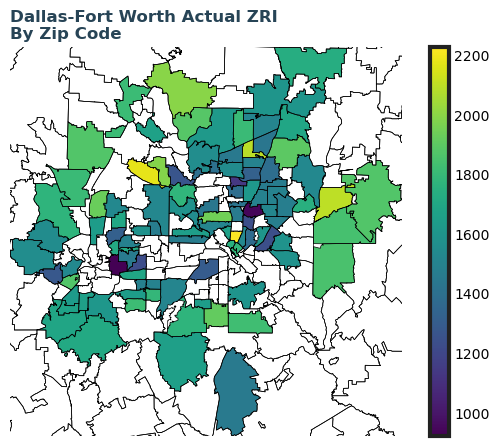

In [33]:
map_ = test[test['Time'].dt.month==4]
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():


    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='Black', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["zori_ssa"], 
    #               scheme='equal_interval', k=4,
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' Actual ZRI\nBy Zip Code')
    plt.show()